In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

In [3]:
df.head

<bound method NDFrame.head of          Destination Port   Flow Duration   Total Fwd Packets  \
0                   54865               3                   2   
1                   55054             109                   1   
2                   55055              52                   1   
3                   46236              34                   1   
4                   54863               3                   2   
...                   ...             ...                 ...   
225740              61374              61                   1   
225741              61378              72                   1   
225742              61375              75                   1   
225743              61323              48                   2   
225744              61326              68                   1   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             0                           12   
1                             1                            6 

In [4]:
# Data cleaning
df.dropna(axis=1, how='all', inplace=True)
df.drop(columns=[col for col in df.columns if 'Unnamed' in col], inplace=True)

In [5]:
# Remove rows with nulls or infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [6]:
print(df.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [7]:
print(df.shape)

(225711, 79)


In [8]:
print(df.isnull().sum())

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64


In [9]:
df.columns = df.columns.str.strip()

In [10]:
print(df.columns.tolist())

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [11]:
df.rename(columns=lambda x: x.strip(), inplace=True)  # Removes leading/trailing spaces

In [12]:
df['Label'] = df['Label'].replace({'BENIGN': 0})
df['Label'] = df['Label'].apply(lambda x: 1 if x != 0 else 0)

In [13]:
X = df.drop('Label', axis=1)
y = df['Label']

In [14]:
X = X.select_dtypes(include=[np.number])

In [15]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Reshape into sequences (for LSTM input)

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
X_seq, y_seq = create_sequences(X_scaled, y.to_numpy(), time_steps=10)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [19]:
print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (180560, 10, 78)
Testing shape: (45141, 10, 78)


In [20]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
model = Sequential([
    # CNN Layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    
    # LSTM Layer
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

C:\Users\saket\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │        15,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,289 (204.25 KB)

 Trainable params: 52,289 (204.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9798 - loss: 0.0470 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 2/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9992 - loss: 0.0040 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 3/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9989 - val_loss: 0.0043
Epoch 4/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9996 - val_loss: 0.0019
Epoch 5/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9996 - loss: 0.0028 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 6/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9996 - val_loss: 0.0019
Epoch 7/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.9995 - val_loss: 0.0023
Epoch 8/15
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9997 - loss: 0

In [26]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9996 - loss: 0.0022

Test Accuracy: 0.9996


In [27]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [28]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19418
           1       1.00      1.00      1.00     25723

    accuracy                           1.00     45141
   macro avg       1.00      1.00      1.00     45141
weighted avg       1.00      1.00      1.00     45141



In [29]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Confusion Matrix:
 [[19405    13]
 [    6 25717]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19418
           1       1.00      1.00      1.00     25723

    accuracy                           1.00     45141
   macro avg       1.00      1.00      1.00     45141
weighted avg       1.00      1.00      1.00     45141



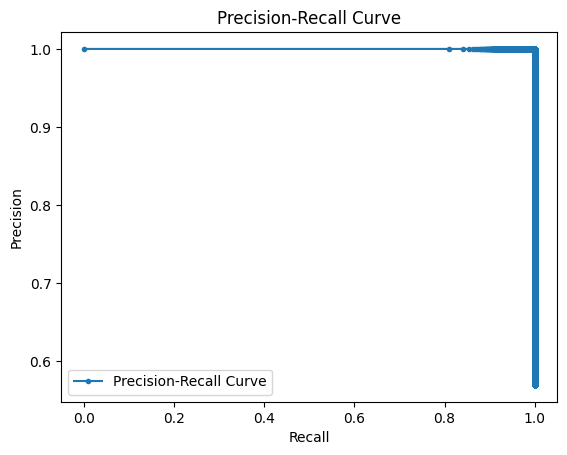

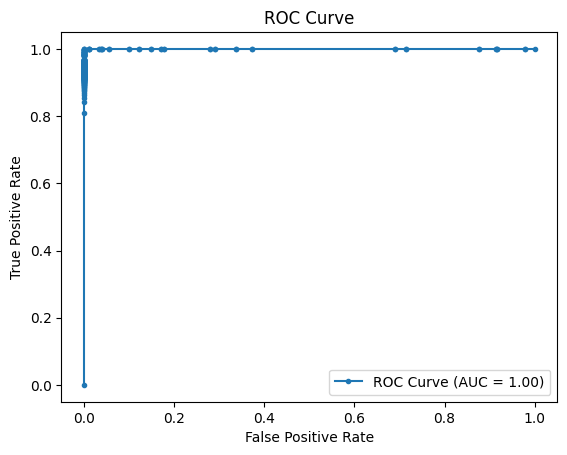

In [30]:
y_pred_prob = model.predict(X_test)  
y_pred_class = (y_pred_prob > 0.5).astype("int32") 

#  Confusion Matrix & Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


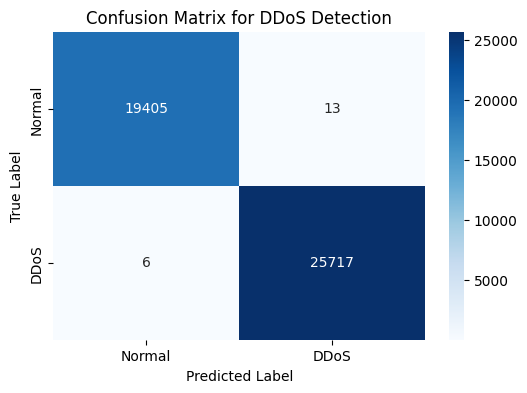

In [32]:
#  predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "DDoS"], yticklabels=["Normal", "DDoS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for DDoS Detection")
plt.show()

In [33]:
model.save("project.keras")